In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 720 kB 5.1 MB/s 
     |████████████████████████████████| 189 kB 51.4 MB/s 
     |████████████████████████████████| 48 kB 5.5 MB/s 
     |████████████████████████████████| 1.2 MB 40.2 MB/s 
     |████████████████████████████████| 55 kB 4.3 MB/s 
     |████████████████████████████████| 558 kB 48.2 MB/s 
     |████████████████████████████████| 51 kB 346 kB/s 
     |████████████████████████████████| 130 kB 48.3 MB/s 


In [ ]:
from fastbook import *
from fastai.vision.widgets import *

In [ ]:
import os
key = os.environ.get('AZURE_SEARCH_KEY', 'c96355e53b0d4afdbdf8c9f0dfd42334')

In [ ]:
fruit_types = 'apple','banana','orange'
path = Path('gdrive/MyDrive/Colab Notebooks/02_production project/data')

In [ ]:
if not path.exists():
    path.mkdir()
    for o in fruit_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} fruit')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [ ]:
fns = get_image_files(path)

In [ ]:
failed = verify_images(fns)

In [ ]:
failed.map(Path.unlink);

In [ ]:
fruits = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=64),
    get_y=parent_label,
    item_tfms=RandomResizedCrop(128, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = fruits.dataloaders(path)

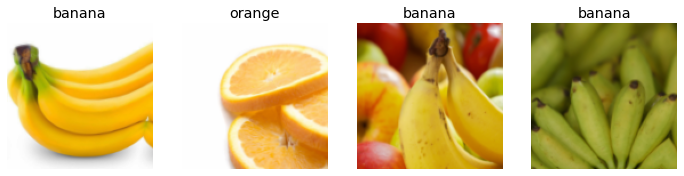

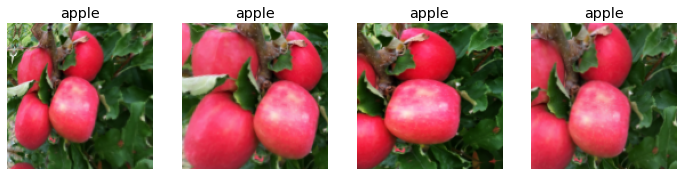

In [ ]:
dls.train.show_batch(max_n=4, nrows=1)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

In [ ]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.534506,0.251497,0.086957,00:28


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


epoch,train_loss,valid_loss,error_rate,time
0,0.550469,0.116850,0.072464,00:28
1,0.398890,0.103753,0.043478,00:29
2,0.276026,0.101812,0.028986,00:28
3,0.210422,0.098597,0.014493,00:28


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency e

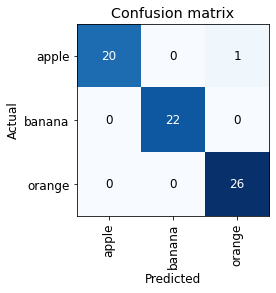

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

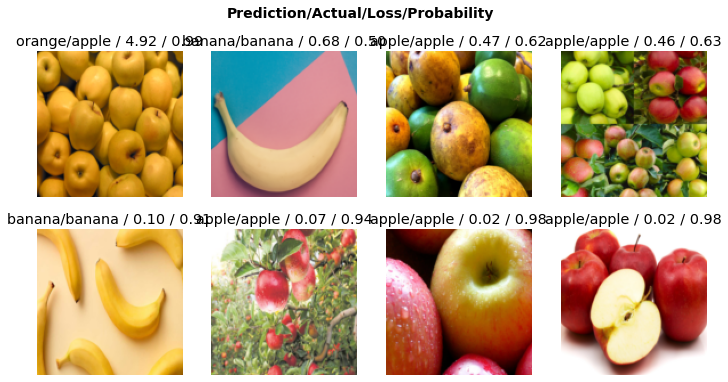

In [ ]:
#interp.plot_top_losses(5, nrows=1)

#Using fix for plot_top_losses from https://forums.fast.ai/t/plot-top-losses-problem/92015
def plot_top_losses_fix(interp, k, largest=True, **kwargs):
        losses,idx = interp.top_losses(k, largest)
        if not isinstance(interp.inputs, tuple): interp.inputs = (interp.inputs,)
        if isinstance(interp.inputs[0], Tensor): inps = tuple(o[idx] for o in interp.inputs)
        else: inps = interp.dl.create_batch(interp.dl.before_batch([tuple(o[i] for o in interp.inputs) for i in idx]))
        b = inps + tuple(o[idx] for o in (interp.targs if is_listy(interp.targs) else (interp.targs,)))
        x,y,its = interp.dl._pre_show_batch(b, max_n=k)
        b_out = inps + tuple(o[idx] for o in (interp.decoded if is_listy(interp.decoded) else (interp.decoded,)))
        x1,y1,outs = interp.dl._pre_show_batch(b_out, max_n=k)
        if its is not None:
            plot_top_losses(x, y, its, outs.itemgot(slice(len(inps), None)), interp.preds[idx], losses,  **kwargs)

plot_top_losses_fix(interp, 8, nrows=2)

In [ ]:
#cleaner = ImageClassifierCleaner(learn)
#cleaner

In [ ]:
#cleaner.delete()

In [ ]:
#for idx in cleaner.delete(): cleaner.fns[idx].unlink()
# for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [ ]:
learn.export()